In [30]:
#..........................案例1:
#.......................... 分类[]：图片分类
#...SGDClassifier ，这是一个线性模型。它所做的全部工作就是分配一个类权重给每一个像素，
# 然后当它看到一张新的图片，它就将加权的像素强度相加，每个类得到一个新的值。所以，因为 3 和 5 只有一小部分的像素有差异，这个模型很容易混淆它们。

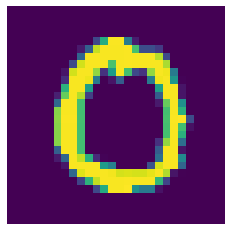

对应的标签： 0.0


In [35]:
from scipy.io import loadmat
mnist=loadmat(r'C:\Users\Wudey\Desktop\mnist-original.mat')
X, y = mnist["data"], mnist["label"]
# 查看数据(储存的28x28的图)
import matplotlib.pyplot as plt
some_digit = X.T[3600]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, interpolation="nearest")
plt.axis("off")
plt.show()
print('对应的标签：',y[0,360])
# 拆分测试与训练
X, y =X.T, y.T.ravel() # .ravel()转为1维度
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# ，一些学习算法对训练样例的顺序敏感，当它们在一行当中得到许多相似的样例，这些算法将会表现得非常差。打乱数据集将保证这种情况不会发生。
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [36]:
# 训练二分类（是否为5）
y_train_5 = (y_train == 5) # bool值
y_test_5 = (y_test == 5)
# 随机梯度下降分类器 SGD
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
print('预测结果：',sgd_clf.predict([X_test[1]]))

预测结果： [False]


In [39]:
# 性能评估
from sklearn.model_selection import cross_val_score
print('K折正确率（accuracy）：',cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy"))
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print('混淆矩阵：\n',confusion_matrix(y_train_5, y_train_pred))

K折正确率（accuracy）： [0.9552  0.9662  0.95965]
混淆矩阵：
 [[53800   779]
 [ 1600  3821]]


X[3600]的决策分数： [1729.42025262]
P值（阈值7千） 0.9257398101619208
R值（阈值7千） 0.30584762958863676


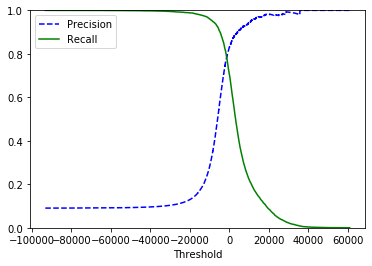

In [48]:
# PR图
# 当正例很少，或者当你关注假正例多于假反例的时候，用PR图
# 准确率/召回率之间的折衷
some_digit = X[36000]
y_scores=sgd_clf.decision_function([some_digit]) # 每个X都会有决策分数
print('X[3600]的决策分数：',y_scores)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
    method="decision_function") # 所有X的决策分数
# 用决策分数来画PR图
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
# 假设阈值选70000
y_train_pred_90 = (y_scores > 7000)
from sklearn.metrics import precision_score, recall_score
print('P值（阈值7千）',precision_score(y_train_5, y_train_pred_90))
print('R值（阈值7千）',recall_score(y_train_5, y_train_pred_90))

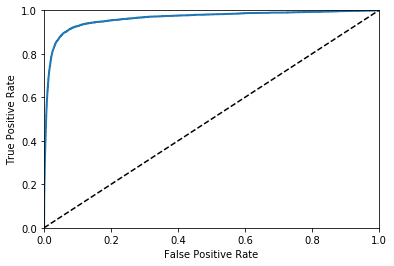

面积（AUC）： 0.9633357020204756


In [53]:
# ROC图（不同阈值下的 FPR、TPR【召回率】）
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()
from sklearn.metrics import roc_auc_score
print('面积（AUC）：',roc_auc_score(y_train_5, y_scores))

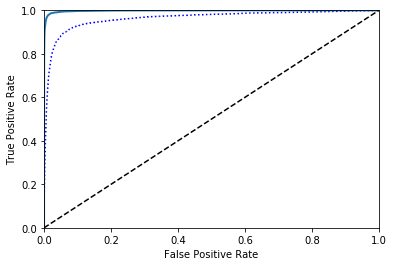

随机森林面积（AUC）： 0.9983608916831711


In [59]:
# 用随机森林来与上述SDG比较
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
# 随机森林没有decision_function，用概率来判断。会给出正例和反例（1-正例）概率
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
    method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.show()
print('随机森林面积（AUC）：',roc_auc_score(y_train_5, y_scores_forest))

In [63]:
# 多分类（多项式分类器）
# 一些算法（比如随机森林分类器或者朴素贝叶斯分类器）可以直接处理多类分类问题。其他一些算法（比如 SVM 分类器或者线性分类器）则是严格的二分类器
# 二分类器处理多分类：
# “一对所有”（OvA）策略：10个类别分为10类，是与不是，识别某事件时，选取10个种预测最好的
# “一对一”（OvO）策略：两两配对，10个类别，需要45个分类器，优点在于每个分类器数据较小。SVM比较适合，因为它在数据量上很难扩展，一般情况，OvA更好
# SDG在预测时其实就是OvA，以下将SDG强制改为OvO
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
# ovo_clf.predict([some_digit])
# 用cross_val_score做简单的训练集交叉验证
print('交叉验证：',cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy"))
# 正则化提高精度
from sklearn.preprocessing import StandardScaler
X_train_scaled = StandardScaler().fit_transform(X_train.astype(np.float64))
print('交叉验证：',cross_val_score(ovo_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"))

交叉验证： [0.91095 0.9197  0.91375]
交叉验证： [0.9162  0.91985 0.91645]


In [65]:
# 多分类（多项式分类器）
# 误差分析
# 跳过GridSearchCV 调试超参数
# 多分类混淆矩阵
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\wudeyuan\Anaconda\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5567,    0,   17,    6,    8,   40,   34,    5,  245,    1],
       [   1, 6413,   37,   21,    3,   44,    5,    7,  201,   10],
       [  28,   28, 5235,   81,   76,   22,   71,   38,  367,   12],
       [  28,   22,  105, 5237,    0,  195,   28,   40,  412,   64],
       [  11,   14,   37,   11, 5214,    7,   36,   22,  343,  147],
       [  27,   12,   25,  149,   53, 4439,   82,   19,  549,   66],
       [  30,   17,   44,    1,   43,   91, 5547,    4,  141,    0],
       [  22,   13,   52,   24,   54,   11,    3, 5687,  198,  201],
       [  17,   62,   38,  100,    2,  122,   32,    8, 5428,   42],
       [  24,   20,   23,   57,  123,   34,    1,  181,  402, 5084]],
      dtype=int64)

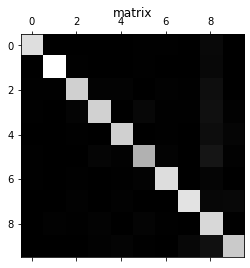

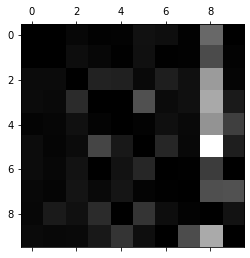

In [69]:
# 多分类（多项式分类器）
# 混淆矩阵(绝对错误)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.title('matrix')
plt.show()
# 混淆矩阵(相对错误)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0) # 用0填充对角线
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
# 努力改善分类器在数字 8 的表现
# 举例子，写一个算法去数闭合的环（比如，数字 8 有两个环，数字 6 有一个， 5 没有）。又或者你可以预处理图片（比如，使用 Scikit-Learn，Pillow， OpenCV）去构造一个模式，比如闭合的环。

In [71]:
# 多标签分类，一个数据多个标签（不是所有分类器都能这么干）
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7) # 大于7定义为大
y_train_odd = (y_train % 2 == 1) # 奇数
y_multilabel = np.c_[y_train_large, y_train_odd] # 类似于zip
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])
# 输出多分类
# 这里没有展开。其实KNN比SDG更加适合这个任务

array([[False,  True]])